In [385]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
% matplotlib inline

## Inputs

In [386]:
n = 4 #number of grids
Pin = 5000 #psi
Pout = 2000 #psi
Pi = 1000
bc_in = 0 #(0 for Neumann, 1 for Dirichlet)
bc_out = 1
A = 200000 #ft^2
Bw = 1
Ct = 1e-5
L = 10000 #ft
Vi = A*L/n #ft^3
delta_t = 1 #day
delta_x = L/n #ft
mu = 1 #cp 
positions_and_rates = [1000,0]
k = np.array([50,50,50,50])
phi = np.array([.2,.2,.2,.2])

In [387]:
def explicit(P0,delta_t, B,Q,T): 
    # function to calculate the Pn+1 using explicit method, all inputs must be of numpy's matrix data type
    return P0 + delta_t*inv(B)*(Q-T*P0)

In [388]:
def implicit(P0,delta_t, B,Q,T):
    # function to calculate the Pn+1 using implicit method, all inputs must be of numpy's matrix data type
    return inv(T + B/delta_t)*(B*P0/delta_t + Q)

In [389]:
def crank_nicholson(P0,delta_t, B,Q,T):
    # function to calculate the Pn+1 using explicit method, all inputs must be of numpy's matrix data type
    theta = .5 # always for crank nicholson
    return inv((1-theta)*T + B/delta_t)*((B/delta_t - theta*T )*P0 + Q)

In [390]:
def compute(k,phi,n,positions_and_rates,delta_x):
    # this function takes in the k vector, phi vector, n number of blocks, positions and rates, and delta x 
    # k, A, Bw, mu, are assumed to be the same so I didn't put it in as part of the inputs, but the function
    # could be easily modified
    # postions and rates should be in the form of [q0,x0,q1,x1,q3,x3...]
    B = np.zeros(shape=(n,n))
    for i in range(0,len(phi)):
        B[i][i] = A*delta_x*phi[i]*Ct/Bw
        
    T = computeHalfTransmissibilities(k,A,Bw,mu,delta_x) # call the separate computeHalfTransmissibilities function

    T1 = k[0]*A/(Bw*mu*delta_x)
    TN = k[len(k)-1]*A/(Bw*mu*delta_x)

    Q = np.zeros(n)
    for i in range (0, len(positions_and_rates),2):
        position = int(positions_and_rates[i+1]/(L/n))
        Q[position] = positions_and_rates[i]
    if bc_out == 1:
        Q[len(Q)-1] = 2*TN*Pout*6.33e-3
    if bc_in == 1:
        Q[0] += 2*TN*Pin*6.33e-3
    Q = np.matrix(Q).transpose()

    P0 = np.matrix([Pi]*n).transpose()
    return B, T, Q, P0

In [391]:
def computeHalfTransmissibilities(k,A,Bw,mu,delta_x):
    
    # this function computes the half transmissibilities
    # k = vecotr
    # A, Bw, mu, and delta x should be constants
    
    # first compute the geometric mean
    # for example, k3/2 = 2(1/k1 + 1/k2)**-1 
    k_geometric_mean = 2*(1/k[:-1] + 1/k[1:])**-1
    
    # compute half transmissibilities
    # for example, t3/2 = k3/2 * A/(Bw*mu*delta_x)
    half_trans = k_geometric_mean*A/(Bw*mu*delta_x)
    
    #print('delta_x being used is', delta_x)
    #print(T1)
    #print(TN)
    
    # in my case, I want to add the non-existing outside blocks (e.g. T1/2 and T9/2 for n = 4)
    # to a copy of half_trans
    # so first i have to compute those values first
    half_trans_full = half_trans
    T1 = k[0]*A/(Bw*mu*delta_x) # value for grid = 0 on left
    TN = k[len(k)-1]*A/(Bw*mu*delta_x) # value for grid = nth block on right
    
    if bc_in == 0: #if inlet is neuman or have no flow, then T1/2 = 0
        half_trans_full = np.insert(half_trans_full,0,0)
    if bc_in == 1: #if inlet is constant pressure, then T1/2 = 2*T1 
        half_trans_full = np.insert(half_trans_full,0,2*T1)

    if bc_out == 0: #if outlet is neuman or have no flow, then T
        half_trans_full = np.insert(half_trans_full,len(half_trans_full),0)
    if bc_out == 1: #if outlet is constant in pressure, then T9/2 = 2*T4
        half_trans_full = np.insert(half_trans_full,len(half_trans_full),2*TN)
    half_trans_full = half_trans_full[:-1] + half_trans_full[1:]

    # now I create the half transmissibilities matrix
    T = np.zeros((len(k),len(k))) # create a matrixf filled with zeros of dimension nxn, length n = how many points k vector has
    for i in range (0, len(half_trans_full)):
        T[i][i] = half_trans_full[i]
    for i in range (1, len(half_trans)+1):
        T[i][i-1] = -1*half_trans[i-1]
    for i in range (0, len(half_trans)):
        T[i][i+1] = -1*half_trans[i]
    T = T*6.33e-3
    return T

In [392]:
def reiterativeCalculation(method, how_many_days,P0,delta_t, B, Q,T):
    # this is a funciton that will compute the Pn+1 values for many, many times for any method that was passed in
    previousP = method(P0,delta_t, B, Q,T) # first iteration
    currentP = previousP 
    for i in range (2,how_many_days+1): # since first iteration is already calculated, this will be the second iteration
        currentP = method(previousP,delta_t, B,Q,T) # compute new P from the previous result
        previousP = currentP
    return(currentP)

## Run your program for the following:

### a.	The values defined in problem #1 – this will help verify the program is working correctly

In [393]:
B, T, Q, P0 = compute(k,phi,n,positions_and_rates,delta_x) #call the compute function to calculate B, T, Q, and P0

In [394]:
P0 # show result of P0

matrix([[1000],
        [1000],
        [1000],
        [1000]])

In [395]:
Q 

matrix([[   1000.],
        [      0.],
        [      0.],
        [ 101280.]])

In [396]:
T

array([[ 25.32, -25.32,   0.  ,   0.  ],
       [-25.32,  50.64, -25.32,   0.  ],
       [  0.  , -25.32,  50.64, -25.32],
       [  0.  ,   0.  , -25.32,  75.96]])

In [397]:
B

array([[ 1000.,     0.,     0.,     0.],
       [    0.,  1000.,     0.,     0.],
       [    0.,     0.,  1000.,     0.],
       [    0.,     0.,     0.,  1000.]])

In [398]:
# Using the values defined in problem #1, check result for Implict Method
implicit(P0,delta_t, B,Q,T)

matrix([[ 1000.9765626 ],
        [ 1000.05091474],
        [ 1001.13611756],
        [ 1047.09168231]])

In [399]:
# Using the values defined in problem #1, check result for Explicit Method
explicit(P0,delta_t, B,Q,T)

matrix([[ 1001.  ],
        [ 1000.  ],
        [ 1000.  ],
        [ 1050.64]])

In [400]:
# Using the values defined in problem #1, check result for Crank-Nicholson Method
crank_nicholson(P0,delta_t, B,Q,T)

matrix([[ 1000.98774378],
        [ 1000.0196381 ],
        [ 1000.60272496],
        [ 1048.79441848]])

In [401]:
# Check again using reiterativeCalculation to see if answer still matches
P_4 = reiterativeCalculation(implicit,1,P0,delta_t, B, Q,T)
P_4

matrix([[ 1000.9765626 ],
        [ 1000.05091474],
        [ 1001.13611756],
        [ 1047.09168231]])

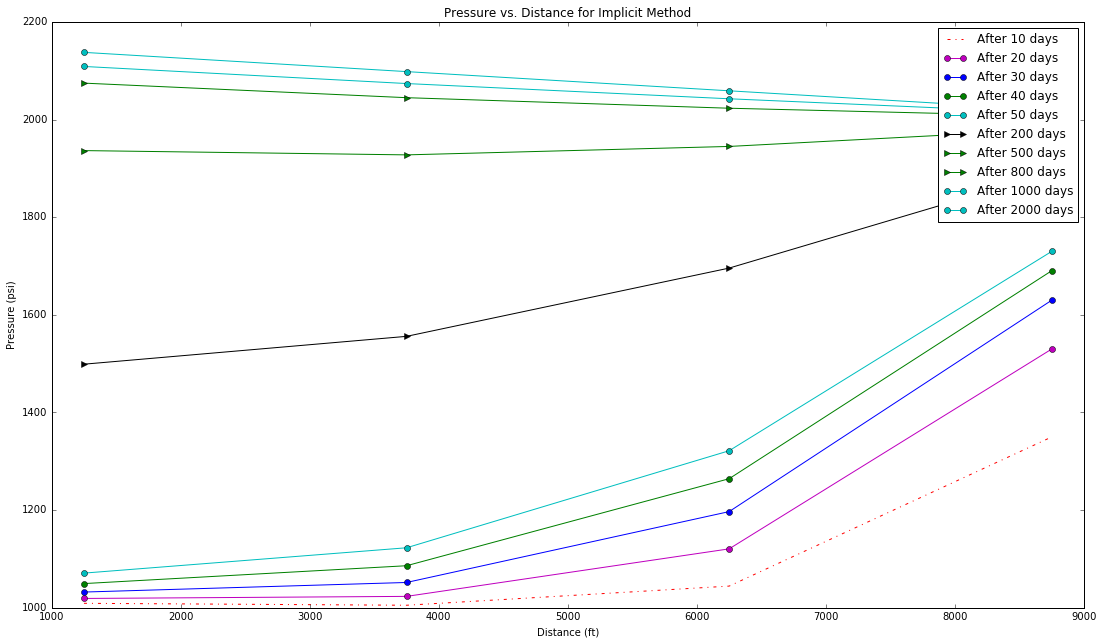

In [402]:
x = np.linspace(delta_x/2, L-(delta_x/2),n)
# Calculate pressure profile for the 115 grid-block system after 10 days, 50 days, and 200 days
P_10 = reiterativeCalculation(implicit,10,P0,delta_t, B, Q,T)
P_20 = reiterativeCalculation(implicit,20,P0,delta_t, B, Q,T)
P_30 = reiterativeCalculation(implicit,30,P0,delta_t, B, Q,T)
P_40 = reiterativeCalculation(implicit,40,P0,delta_t, B, Q,T)
P_50 = reiterativeCalculation(implicit,50,P0,delta_t, B, Q,T)
P_200 = reiterativeCalculation(implicit,200,P0,delta_t, B, Q,T)
P_500 = reiterativeCalculation(implicit,500,P0,delta_t, B, Q,T)
P_800 = reiterativeCalculation(implicit,800,P0,delta_t, B, Q,T)
P_1000 = reiterativeCalculation(implicit,1000,P0,delta_t, B, Q,T)
P_2000 = reiterativeCalculation(implicit,2000,P0,delta_t, B, Q,T)

# Plot
temp_figure = plt.figure()
temp_figure.set_size_inches(18.5, 10.5)
plt.plot(x,P_10,'-.',color='r',label="After 10 days")
plt.plot(x,P_20,'o-',color='m',label="After 20 days")
plt.plot(x,P_30,'o-',color='b',label="After 30 days")
plt.plot(x,P_40,'o-',color='g',label="After 40 days")
plt.plot(x,P_50,'o-',color='c',label="After 50 days")
plt.plot(x,P_200,'>-',color='k',label="After 200 days")
plt.plot(x,P_500,'>-',color='g',label="After 500 days")
plt.plot(x,P_800,'>-',color='g',label="After 800 days")
plt.plot(x,P_1000,'o-',color='c',label="After 1000 days")
plt.plot(x,P_2000,'o-',color='c',label="After 2000 days")

plt.ylabel('Pressure (psi)')
plt.xlabel('Distance (ft)')
plt.title('Pressure vs. Distance for Implicit Method')
plt.legend()
plt.show()

### b.	The same problem (i.e. same fluid/reservoir properties and boundary conditions) but now with 115 grid blocks and using a spatially-varying permeability and porosity. The attached data file includes the reservoir permeability and porosity provided by a geologist.  Plot the pressure profile for the 115 grid-block system after 10 days, 50 days, and 200 days. Use a time-step size of 1.0 days. 

In [403]:
n = 4 #number of grids
Pin = 0 #psi
Pout = 500 #psi
Pi = 1000
bc_in = 0 #(0 for Neumann, 1 for Dirichlet)
bc_out = 1
A = 80000 #ft^2
Bw = 1
Ct = 1e-5
L = 4000 #ft
Vi = A*L/n #ft^3
delta_t = 1
mu = 1 #cp 
positions_and_rates = [10000,5,-10000,1495]
n_new = 115
delta_x_new = L/n_new
k_new = np.loadtxt('Permeability.txt')
phi_new = np.loadtxt('Porosity.txt')
T1 = k_new[0]*A/(Bw*mu*delta_x)
TN = phi_new[len(k)-1]*A/(Bw*mu*delta_x)
x = np.linspace(delta_x_new/2, L-(delta_x_new/2),n_new)

In [404]:
# again, compute B, T, Q, P0 for new sets of input
# now with 115 grid blocks and using a spatially-varying permeability and porosity loaded from text files
new_B, new_T, new_Q, new_P0 = compute(k_new, phi_new, n_new,positions_and_rates,delta_x_new)

In [405]:
new_B

array([[  3.06517796,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   3.64079702,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  12.62565551, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   2.97314251,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          3.41110283,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   9.4922267 ]])

In [406]:
new_T

array([[  696.56175869,  -696.56175869,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ -696.56175869,  1879.40433417, -1182.84257548, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        , -1182.84257548,  2684.38753339, ...,
            0.        ,     0.        ,     0.        ],
       ..., 
       [    0.        ,     0.        ,     0.        , ...,
         1604.17257205,  -664.9214836 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
         -664.9214836 ,  1715.26297157, -1050.34148797],
       [    0.        ,     0.        ,     0.        , ...,
            0.        , -1050.34148797,  5023.51467688]])

In [407]:
new_Q

matrix([[   10000.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.       ],
        [       0.  

In [408]:
implicit(P0,delta_t, B,Q,T)

matrix([[ 1000.9765626 ],
        [ 1000.05091474],
        [ 1001.13611756],
        [ 1047.09168231]])

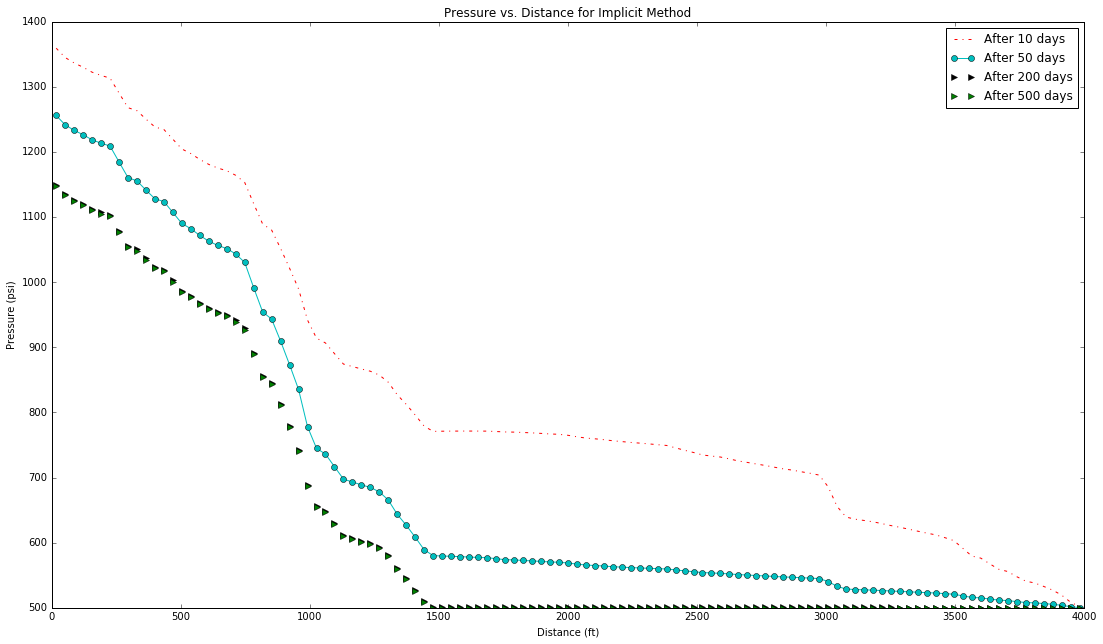

In [409]:
# Calculate pressure profile for the 115 grid-block system after 10 days, 50 days, and 200 days
P_10 = reiterativeCalculation(implicit,10,new_P0,delta_t, new_B, new_Q,new_T)
P_50 = reiterativeCalculation(implicit,50,new_P0,delta_t, new_B, new_Q,new_T)
P_200 = reiterativeCalculation(implicit,200,new_P0,delta_t, new_B, new_Q,new_T)
P_500 = reiterativeCalculation(implicit,500,new_P0,delta_t, new_B, new_Q,new_T)

# Plot
temp_figure = plt.figure()
temp_figure.set_size_inches(18.5, 10.5)
plt.plot(x,P_10,'-.',color='r',label="After 10 days")
plt.plot(x,P_50,'o-',color='c',label="After 50 days")
plt.plot(x,P_200,'>',color='k',label="After 200 days")
plt.plot(x,P_500,'>',color='g',label="After 500 days")

plt.ylabel('Pressure (psi)')
plt.xlabel('Distance (ft)')
plt.title('Pressure vs. Distance for Implicit Method')
plt.legend()
plt.show()